# 2. Network Analysis

Si procede con l'analisi del grafo generato dal dataset come illustrato nella [prima parte](../data_collection/1_data.ipynb).

## 2.1. Generalità

Si calcolano i parametri principali del grafo. In primo luogo si riprende quanto svolto nella prima parte (per generare il grafo).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import networkx as nx
import powerlaw as pl
import numpy as np
import seaborn as sns
from collections import Counter
import csv

# Serve a risolvere i problemi di codifica dei caratteri asiatici
plt.rcParams['font.sans-serif'] = ['Meiryo']
plt.rcParams['axes.unicode_minus'] = False


LINKS_PATH = "../data_collection/data/links.csv"
ARTISTS_PATH = "../data_collection/data/artists.csv"

adf = pd.read_csv(ARTISTS_PATH, encoding="utf-8")
ldf = pd.read_csv(LINKS_PATH, encoding="utf-8")
ars = pd.concat([ldf["IDArtista1"], ldf["IDArtista2"]]).unique()

g = nx.Graph()
g.add_nodes_from(ars)

nodes = g.number_of_nodes()

with open(LINKS_PATH, "r", encoding="utf-8") as f:
    
    reader = csv.reader(f)
    next(reader)
    
    for parts in reader:
        if len(parts) < 6:
            continue
        
        id1, ar1, id2, ar2, sRatio, jRatio = parts[:6]
        
        try:
            id1 = int(id1)
            id2 = int(id2)
            sRatio = float(sRatio)
            jRatio = float(jRatio)
        except ValueError:
            continue
        
        g.add_edge(id1, id2, sRatio=sRatio, jRatio=jRatio)
        
        g.nodes[id1]["name"] = ar1
        g.nodes[id2]["name"] = ar2


edges = g.number_of_edges()

directed = "" if g.is_directed() else " non"
density = np.format_float_scientific(nx.density(g), precision=5, exp_digits=2)

print(f"{nodes} artisti connessi su {len(adf)} ({round((nodes / len(adf)) * 100, 2)}%).\n{edges} archi nel dataset.\nIl grafo{directed} è orientato.\n\nLa densità è di {density}.")

11745 artisti connessi su 28870 (40.68%).
98890 archi nel dataset.
Il grafo non è orientato.

La densità è di 1.43388e-03.


## 2.2. Distribuzione di grado

Si svolge un'analisi relativa al grado dei nodi del grafo.

Ecco una tabella con gli artisti connessi e i rispettivi gradi:

In [2]:
degDict = {g.nodes[node]["name"]: degree for node, degree in g.degree() if "name" in g.nodes[node]}

degFrame = pd.DataFrame(list(degDict.items()), columns=["Artista", "Grado"]).sort_values(by=["Grado", "Artista"], ascending=[False, True])

degFrame

Artista  Grado
5181       Darius Rucker    159
4273         Keith Urban    159
5154          pinocchioP    155
5106      Dierks Bentley    154
5158     Scotty McCreery    154
...                  ...    ...
9638                高橋邦幸      1
9896                高田雅史      1
5190               黒石ひとみ      1
11040  ꉈꀧ꒒꒒ꁄꍈꍈꀧ꒦ꉈ ꉣꅔꎡꅔꁕꁄ      1
9550                 에일리      1

[11743 rows x 2 columns]

Si calcola il **grado medio**. Ci sono due strade che si possono percorrere:

* Calcolando il rapporto tra il numero di righe del CSV e il numero di artisti presenti nel medesimo;
* Calcolando la somma dei gradi in ```degDict``` dividendo per il numero di record.

Lo scarto tra questi due metodi è minimo. Per completezza si mostra in entrambi i modi:

* Primo metodo

In [3]:
avgDeg = round((len(ldf) / len(ars)), 5)
print("Grado medio: ", avgDeg)

Grado medio:  8.4206


* Secondo metodo

    Poiché non è orientato si divide per due:

In [4]:
avgDeg = round((sum(degDict.values()) / (2 * len(degDict))), 5)
print("Grado medio: ", avgDeg)

Grado medio:  8.42093


Si computa il grafico per la distribuzione di grado. **Non** considerando i pesi avremo:

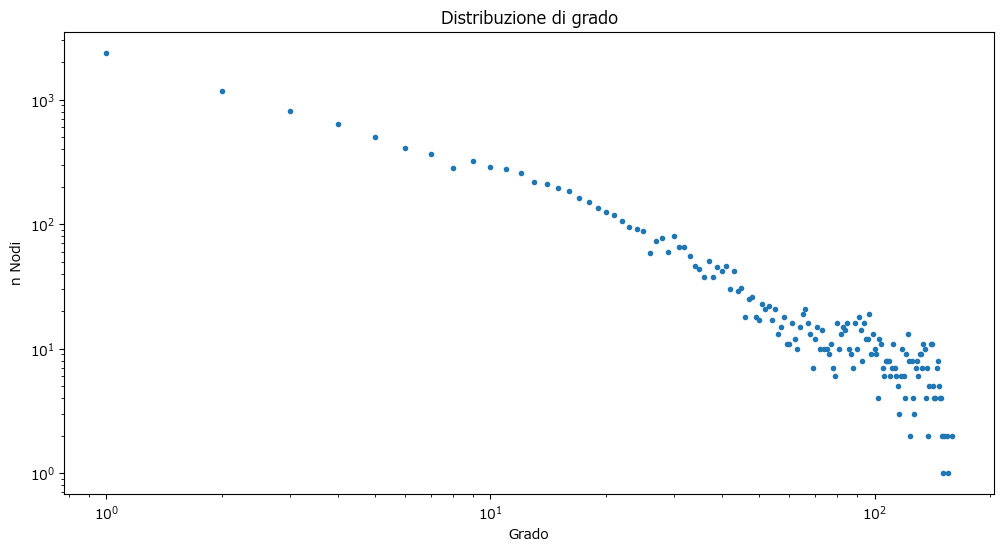

In [5]:
h = nx.degree_histogram(g)

def degDist(h):
    plt.figure(figsize=(12, 6))
    plt.plot(range(0, len(h)), h, ".")
    plt.title("Distribuzione di grado")
    plt.xlabel("Grado")
    plt.ylabel("n Nodi")
    plt.loglog()
    plt.show()

degDist(h)

Invece, qualora si prendessero in considerazione i pesi, si otterrebbe un grafico del tipo:

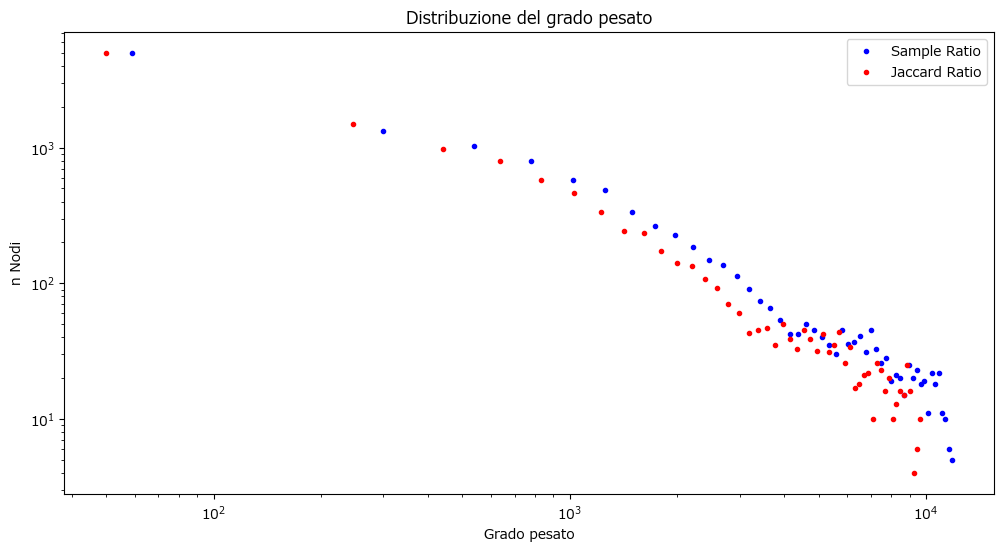

In [6]:
def wDegDist(g):

    colors = ["blue", "red"]
    labels = ["Sample Ratio", "Jaccard Ratio"]
    
    sRatioDegs = [sum(data.get("sRatio", 1) for _, _, data in g.edges(n, data=True)) for n in g.nodes()]
    jRatioDegs = [sum(data.get("jRatio", 1) for _, _, data in g.edges(n, data=True)) for n in g.nodes()]

    sHist, sBins = np.histogram(sRatioDegs, bins=50)
    jHist, jBins = np.histogram(jRatioDegs, bins=50)

    plt.figure(figsize=(12, 6))

    plt.plot(sBins[:-1], sHist, ".", markersize=6, color=colors[0], label=labels[0])
    plt.plot(jBins[:-1], jHist, ".", markersize=6, color=colors[1], label=labels[1])

    plt.title("Distribuzione del grado pesato")
    plt.xlabel("Grado pesato")
    plt.ylabel("n Nodi")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()

    plt.show()

wDegDist(g)

Si illustrano di seguito i migliori valori non minimali in termini di **distribuzione di potenza**, **CDF** e **CCDF** sia per i nodi non pesati che diversificati per Sample e Jaccard Ratio:

Distribuzioni non pesate
Calculating best minimal value for power law fit


C:\Users\calog\AppData\Local\Temp\ipykernel_17888\864076880.py:13: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim((min(dgCount), max(dgCount)))


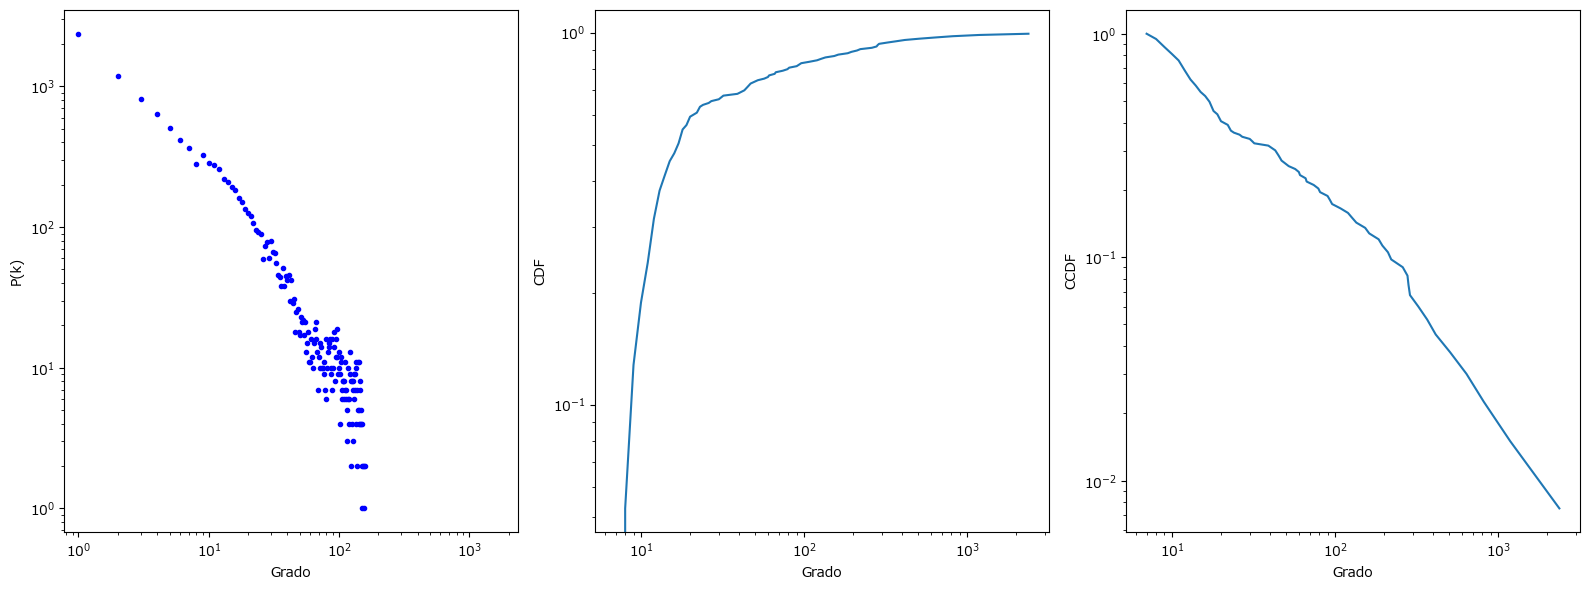

In [7]:
def plotDist(G):
    M = nx.to_scipy_sparse_array(G)
    
    dg = np.array([d[1] for d in G.degree()])
    dgCount = np.bincount(dg)
    fit = pl.Fit(dgCount + 1, fit_method='KS')
    fig = plt.figure(figsize=(16, 6))

    """ Plot Distribution """
    plt.subplot(1, 3, 1)
    plt.plot(range(len(dgCount)), dgCount, 'b.')
    plt.loglog()
    plt.xlim((min(dgCount), max(dgCount)))
    plt.xlabel('Grado')
    plt.ylabel('P(k)')

    """ Plot CDF """
    plt.subplot(1, 3, 2)
    fit.plot_cdf()
    plt.xlabel("Grado")
    plt.ylabel('CDF')

    """ Plot CCDF """
    plt.subplot(1, 3, 3)
    fit.plot_ccdf()
    plt.ylabel('CCDF')
    plt.xlabel('Grado')
    
    plt.tight_layout()
    plt.show()


print(f"Distribuzioni non pesate")
plotDist(g)

Distribuzioni pesate
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


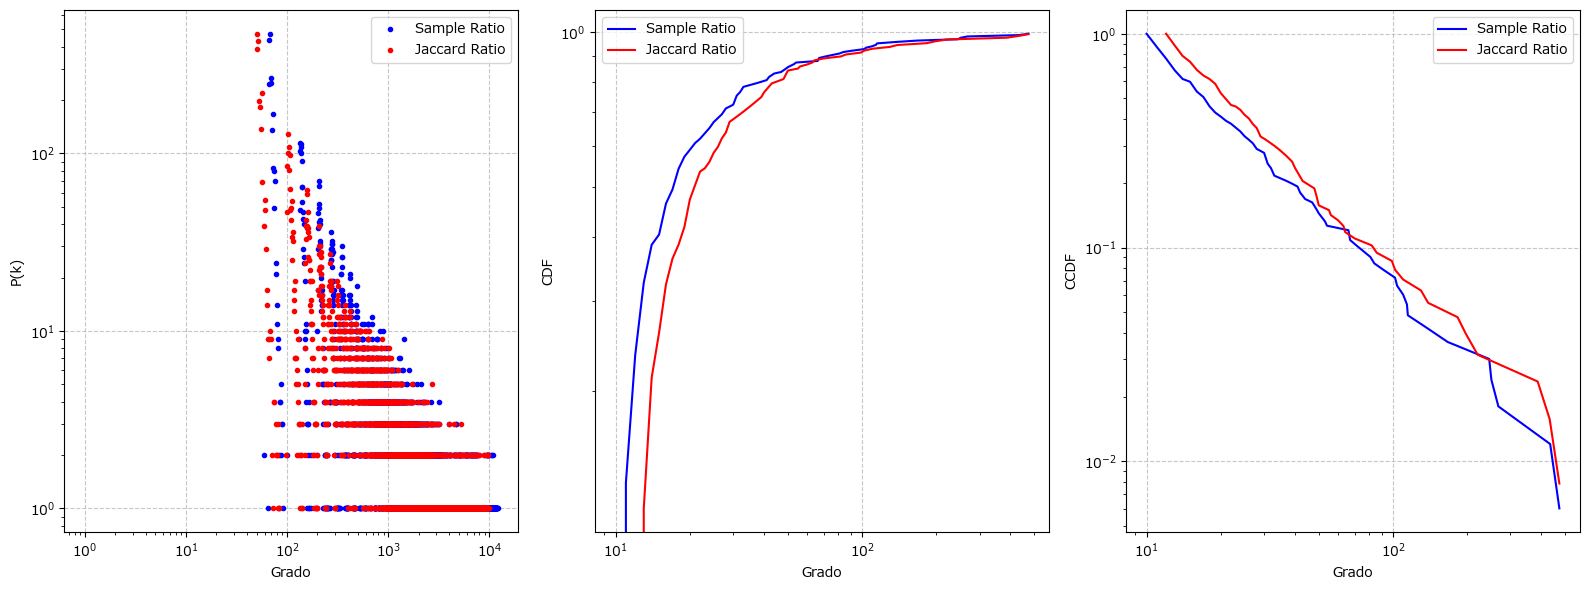

In [8]:
def wPlotDist(G):
    
    M = nx.to_scipy_sparse_array(G)
    
    sDegs = np.array([sum(data.get("sRatio", 1) for _, _, data in G.edges(n, data=True)) for n in G.nodes()])
    jDegs = np.array([sum(data.get("jRatio", 1) for _, _, data in G.edges(n, data=True)) for n in G.nodes()])
    
    sDegCount = np.bincount(sDegs.astype(int))
    jDegCount = np.bincount(jDegs.astype(int))

    sFit = pl.Fit(sDegCount + 1, fit_method='KS')
    jFit = pl.Fit(jDegCount + 1, fit_method='KS')

    fig = plt.figure(figsize=(16, 6))

    """ Plot Distribution """
    plt.subplot(1, 3, 1)
    plt.plot(range(len(sDegCount)), sDegCount, 'b.', label="Sample Ratio")
    plt.plot(range(len(jDegCount)), jDegCount, 'r.', label="Jaccard Ratio")
    plt.loglog()
    plt.xlabel('Grado')
    plt.ylabel('P(k)')
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)

    """ Plot CDF """
    plt.subplot(1, 3, 2)
    sFit.plot_cdf(color="blue", label="Sample Ratio")
    jFit.plot_cdf(color="red", label="Jaccard Ratio")
    plt.xlabel("Grado")
    plt.ylabel('CDF')
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)

    """ Plot CCDF """
    plt.subplot(1, 3, 3)
    sFit.plot_ccdf(color="blue", label="Sample Ratio")
    jFit.plot_ccdf(color="red", label="Jaccard Ratio")
    plt.xlabel("Grado")
    plt.ylabel('CCDF')
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

print(f"Distribuzioni pesate")
wPlotDist(g)

Troviamo i **grafi ER** e **BA** corrispondenti. Per il grafo ER si considera come probabilità la densità del grafo in analisi.

### Grafo ER

In [9]:
gER = nx.erdos_renyi_graph(len(ars), nx.density(g))

Si analizzano le generalità del **grafo ER** associato:

In [10]:
ERNodes = gER.number_of_nodes()
EREdges = gER.number_of_edges()

ERAvgDeg = round(sum(dict(gER.degree()).values()) / (len(gER)), 5)
ERDensity = np.format_float_scientific(nx.density(gER), precision=5, exp_digits=2)

ERComponents = nx.number_connected_components(gER)
ERClustering = np.format_float_scientific(nx.average_clustering(gER), precision=5, exp_digits=2)

print(f"== GRAFO ER ==\n\n{ERNodes} nodi\t{EREdges} archi\nGrado medio: {ERAvgDeg}\tDensità: {ERDensity}\nComponenti connesse: {ERComponents}\nClustering medio: {ERClustering}")

== GRAFO ER ==

11745 nodi	98479 archi
Grado medio: 16.76952	Densità: 1.42792e-03
Componenti connesse: 1
Clustering medio: 1.46001e-03


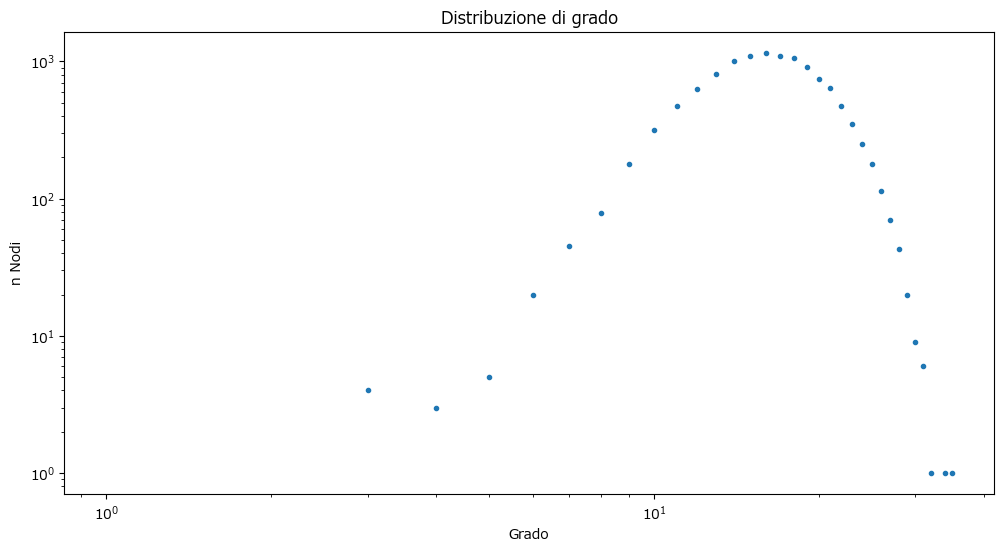

In [11]:
hER = nx.degree_histogram(gER)
degDist(hER)

### Grafo BA

In [12]:
gBA = nx.barabasi_albert_graph(len(ars), 3)

Si analizzano le generalità del **grafo BA** associato:

In [13]:
BANodes = gBA.number_of_nodes()
BAEdges = gBA.number_of_edges()

BAAvgDeg = round(sum(dict(gBA.degree()).values()) / (len(gBA)), 5)
BADensity = np.format_float_scientific(nx.density(gBA), precision=5, exp_digits=2)

BAComponents = nx.number_connected_components(gBA)
BAClustering = np.format_float_scientific(nx.average_clustering(gBA), precision=5, exp_digits=2)

def regime(density, nodes):
    if density < (1 / nodes):
        return "Subcritical"
    elif density == (1 / nodes):
        return "Critical"
    elif density > (1 / nodes):
        if density > (np.log(nodes) / nodes):
            return "Connected"
        return "Supercritical"

print(f"== GRAFO BA ==\n\n{BANodes} nodi\t{BAEdges} archi\nGrado medio: {BAAvgDeg}\tDensità: {BADensity}\nComponenti connesse: {BAComponents}\nClustering medio: {BAClustering}\n")
print(f"Regime: {regime(float(BADensity), BANodes)}")

== GRAFO BA ==

11745 nodi	35226 archi
Grado medio: 5.99847	Densità: 5.10769e-04
Componenti connesse: 1
Clustering medio: 5.16307e-03

Regime: Supercritical


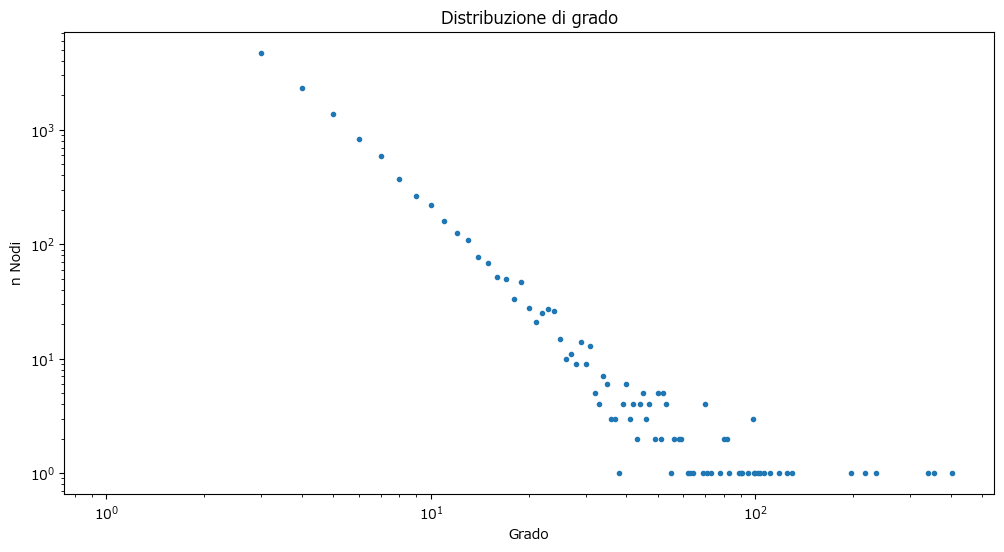

In [14]:
hBA = nx.degree_histogram(gBA)
degDist(hBA)

Mettiamo a confronto le caratteristiche del **grafo principale**, di quello **ER** e di quello **BA**:

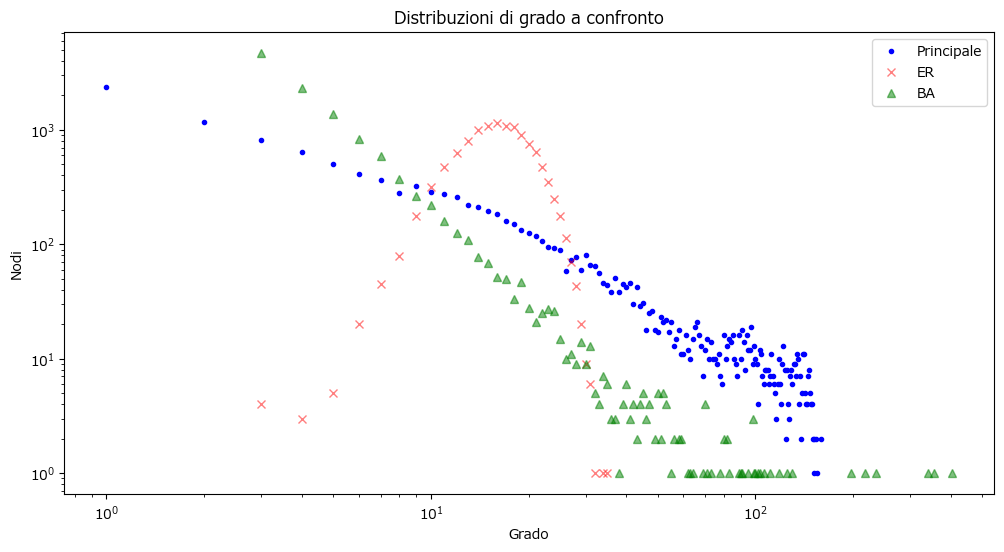

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(range(0, len(h)), h, ".", color="blue", label = 'Principale')
plt.plot(range(0, len(hER)), hER, "x", color ='red', label = 'ER', alpha = 0.5)
plt.plot(range(0, len(hBA)), hBA, "^", color = 'green', label = 'BA', alpha = 0.5)
plt.legend()
plt.title("Distribuzioni di grado a confronto")
plt.xlabel("Grado")
plt.ylabel("Nodi")

plt.loglog()
plt.show()

## 2.3. Distribuzione dei ratio

Proviamo a mostrare come sono distribuiti i ratio nel dataset. Per far questo è stata adottata una distribuzione normale.
Prima si calcolano la media e la deviazione standard dei pesi. Dopodiché si creano gli assi con l'intervallo dei pesi (```x```) e i valori della curva della ditribuzione normale (```y```).

Per il **Sample Ratio** (in blu) e il **Jaccard Ratio** (in rosso) sono le seguenti:

Il Sample Ratio medio è 72.686.
Il Jaccard Ratio medio è 57.387.



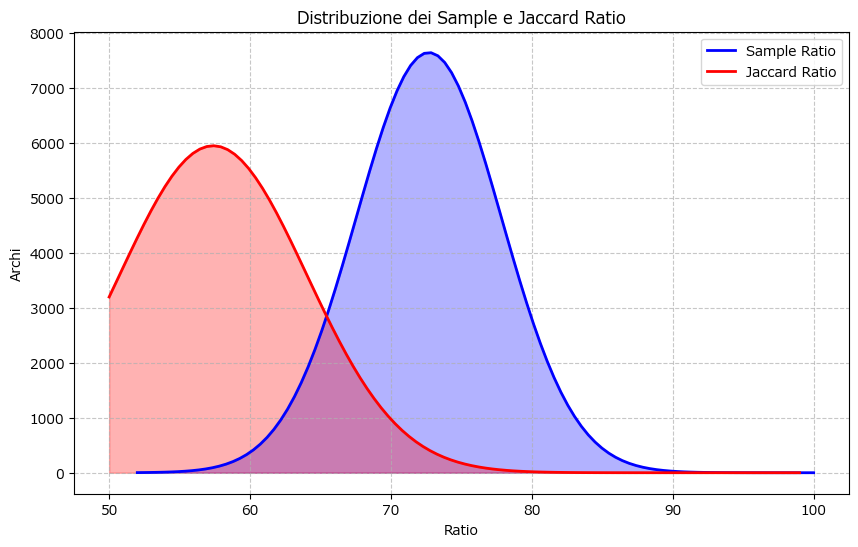

In [16]:
def weightMean(g, ratio="sRatio"):
    total = sum(g.edges[e][ratio] for e in g.edges)
    return total / edges

sAvg = round(weightMean(g, ratio="sRatio"), 3)
jAvg = round(weightMean(g, ratio="jRatio"), 3)

print(f"Il Sample Ratio medio è {sAvg}.\nIl Jaccard Ratio medio è {jAvg}.\n")

# Distribuzione dei ratio

def wDist(g):
    plt.figure(figsize=(10, 6))
    
    for ratio, color, label in [("sRatio", "blue", "Sample Ratio"), ("jRatio", "red", "Jaccard Ratio")]:
        weights = [data[ratio] for _, _, data in g.edges(data=True)]
        
        mu, sigma = np.mean(weights), np.std(weights)
        x = np.linspace(min(weights), max(weights), 100)
        y = norm.pdf(x, mu, sigma) * len(weights)
        
        plt.plot(x, y, color=color, linewidth=2, label=label)
        plt.fill_between(x, y, alpha=0.3, color=color)
    
    plt.xlabel("Ratio")
    plt.ylabel("Archi")
    plt.title("Distribuzione dei Sample e Jaccard Ratio")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    
    plt.show()

wDist(g)

## 2.4. Connected Components

Ecco la lista dei nodi vicini a un nodo generico con un determinato ```id``` (ad esempio uguale a 1):

In [17]:
id = 1

try:
    name = g.nodes[id]["name"]
    nbors = list(g.neighbors(id))

    print(f"== Vicini di {name.upper()} ({id}) ({len(nbors)} artisti) ==\n")
    for nbor in nbors:
        print(f"{nbor}. {g.nodes[nbor]['name']} (S: {g.edges[id, nbor]['sRatio']}, J: {g.edges[id, nbor]['jRatio']})")
except:
    print(f"Artista [{id}] non collegato.")

== Vicini di ANNALISA (1) (29 artisti) ==

5. Elodie (S: 80.0, J: 67.0)
6. Emma (S: 75.0, J: 60.0)
9. Clara (S: 67.0, J: 50.0)
10. Francesca Michielin (S: 73.0, J: 57.99999999999999)
12. The Kolors (S: 69.0, J: 53.0)
15. Marco Mengoni (S: 74.0, J: 59.0)
16. Alessandra Amoroso (S: 69.0, J: 53.0)
18. Levante (S: 69.0, J: 53.0)
19. Noemi (S: 68.0, J: 51.0)
20. Paola & Chiara (S: 72.0, J: 56.99999999999999)
21. Tananai (S: 69.0, J: 52.0)
22. sangiovanni (S: 73.0, J: 57.99999999999999)
23. Elettra Lamborghini (S: 66.0, J: 50.0)
24. Giorgia (S: 70.0, J: 54.0)
26. Arisa (S: 67.0, J: 50.0)
30. Loredana Bertè (S: 67.0, J: 51.0)
31. Giusy Ferreri (S: 70.0, J: 53.0)
34. Diodato (S: 66.0, J: 50.0)
35. Pinguini Tattici Nucleari (S: 67.0, J: 50.0)
36. Michele Bravi (S: 67.0, J: 50.0)
39. Ermal Meta (S: 68.0, J: 52.0)
42. Takagi & Ketra (S: 66.0, J: 50.0)
44. Malika Ayane (S: 67.0, J: 51.0)
46. Ariette (S: 68.0, J: 51.0)
60. Nina Zilli (S: 70.0, J: 53.0)
63. Tommaso Paradiso (S: 68.0, J: 52.0)
93. Mo

Da questo generiamo l'***ego* graph** (il grafo dei vicini del nodo citato):

C:\Users\calog\AppData\Local\Temp\ipykernel_17888\3652605522.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Blues", 256) if ratio == 'sRatio' else plt.cm.get_cmap("Reds", 256)


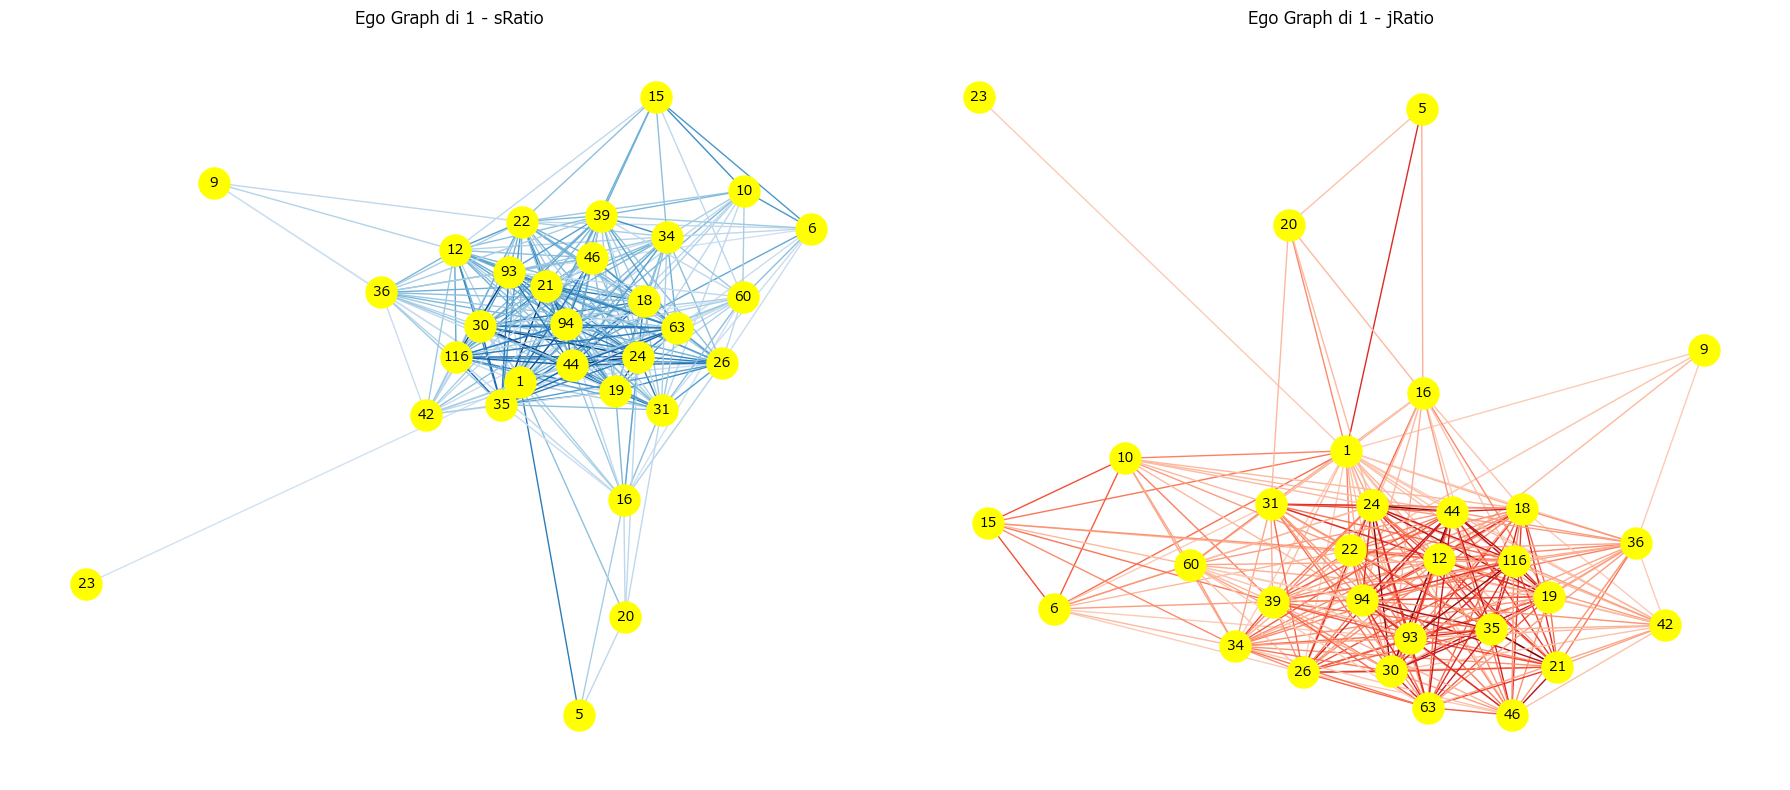

In [18]:
# Indice per spostare il range cromatico (più tende a 1, meno la differenza cromatica è percettibile). 
# In questo modo più è intenso il colore dell'arco, maggiore è il valore del Ratio.

chrThreshold = 0.2

def egoGraph(g, id, ratio="sRatio", ax=None):
    try:
        
        ego = nx.ego_graph(g, id)
        edges = list(ego.edges)
        weights = np.array([ego[u][v][ratio] for u, v in edges])

        minW, maxW = min(weights), max(weights)
        normWgh = (weights - minW) / (maxW - minW) if maxW != minW else np.ones_like(weights)
        normWgh = normWgh * (1 - chrThreshold) + chrThreshold

        cmap = plt.cm.get_cmap("Blues", 256) if ratio == 'sRatio' else plt.cm.get_cmap("Reds", 256)
        colors = cmap(normWgh)

        pos = nx.spring_layout(ego)
        nx.draw(ego, pos, with_labels=True, edge_color=colors, node_size=500, font_size=10,
                node_color='yellow', ax=ax)

        ax.set_title(f"Ego Graph di {id} - {ratio}")
    except Exception as e:
        print(f"Artista [{id}] non esistente.")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

egoGraph(g, id, ratio='sRatio', ax=axes[0])
egoGraph(g, id, ratio='jRatio', ax=axes[1])

plt.tight_layout()
plt.show()

Calcoliamo il numero di **componenti connesse** del grafo e visualizziamo il subgraph corrispondente con i relativi pesi.

In basso visualizziamo anche il componente maggiore:

Il grafo è composto da 800 componenti connesse.
Il componente più grande è il 37 con 920 nodi.


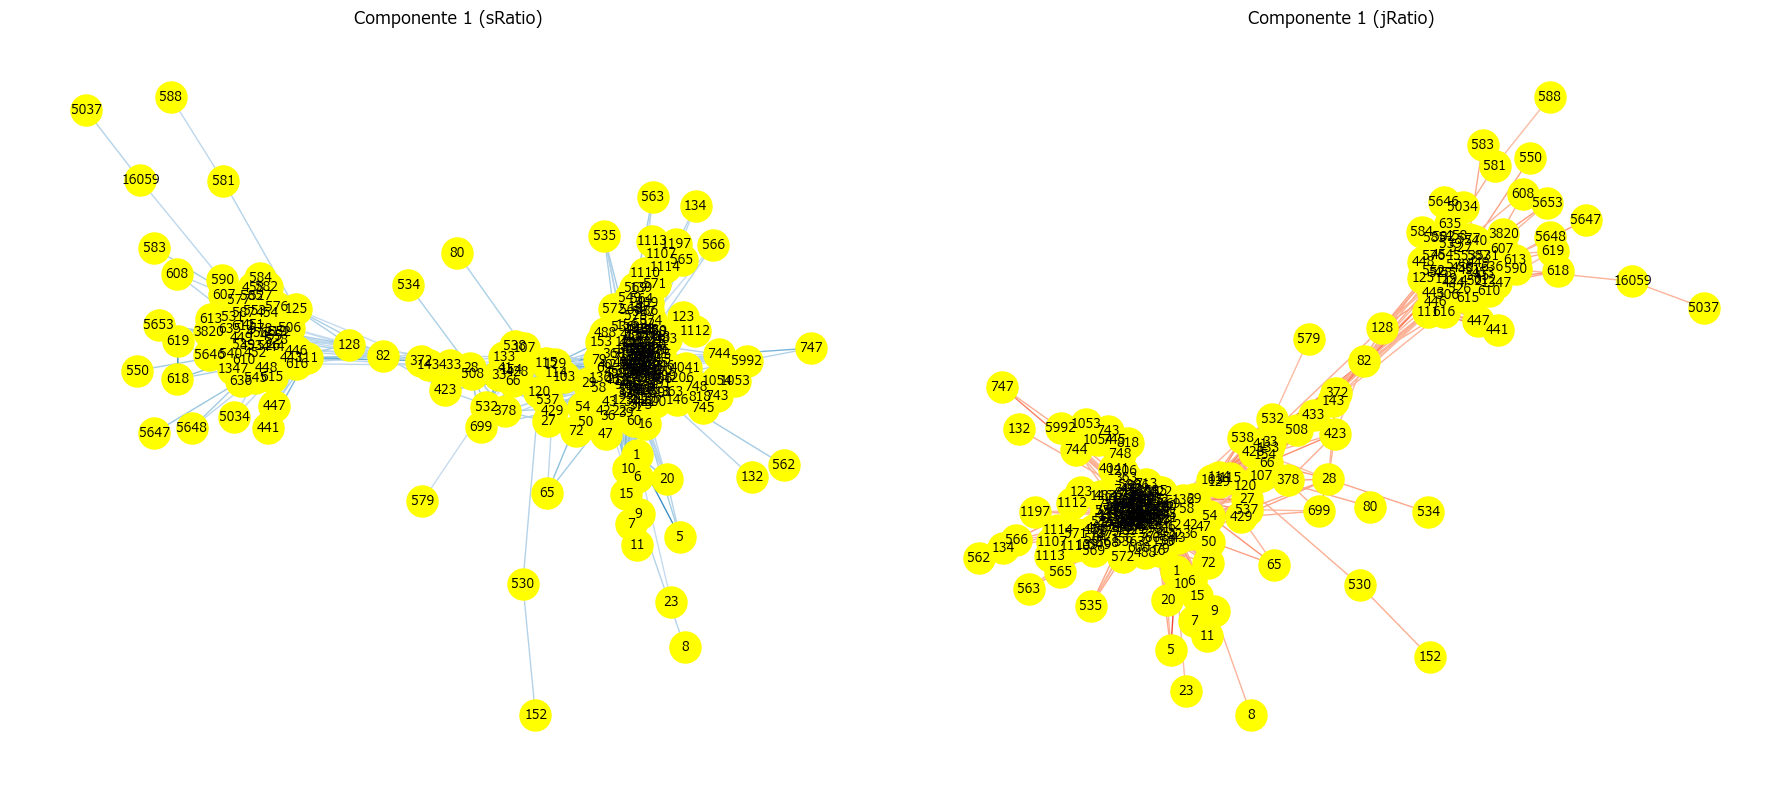

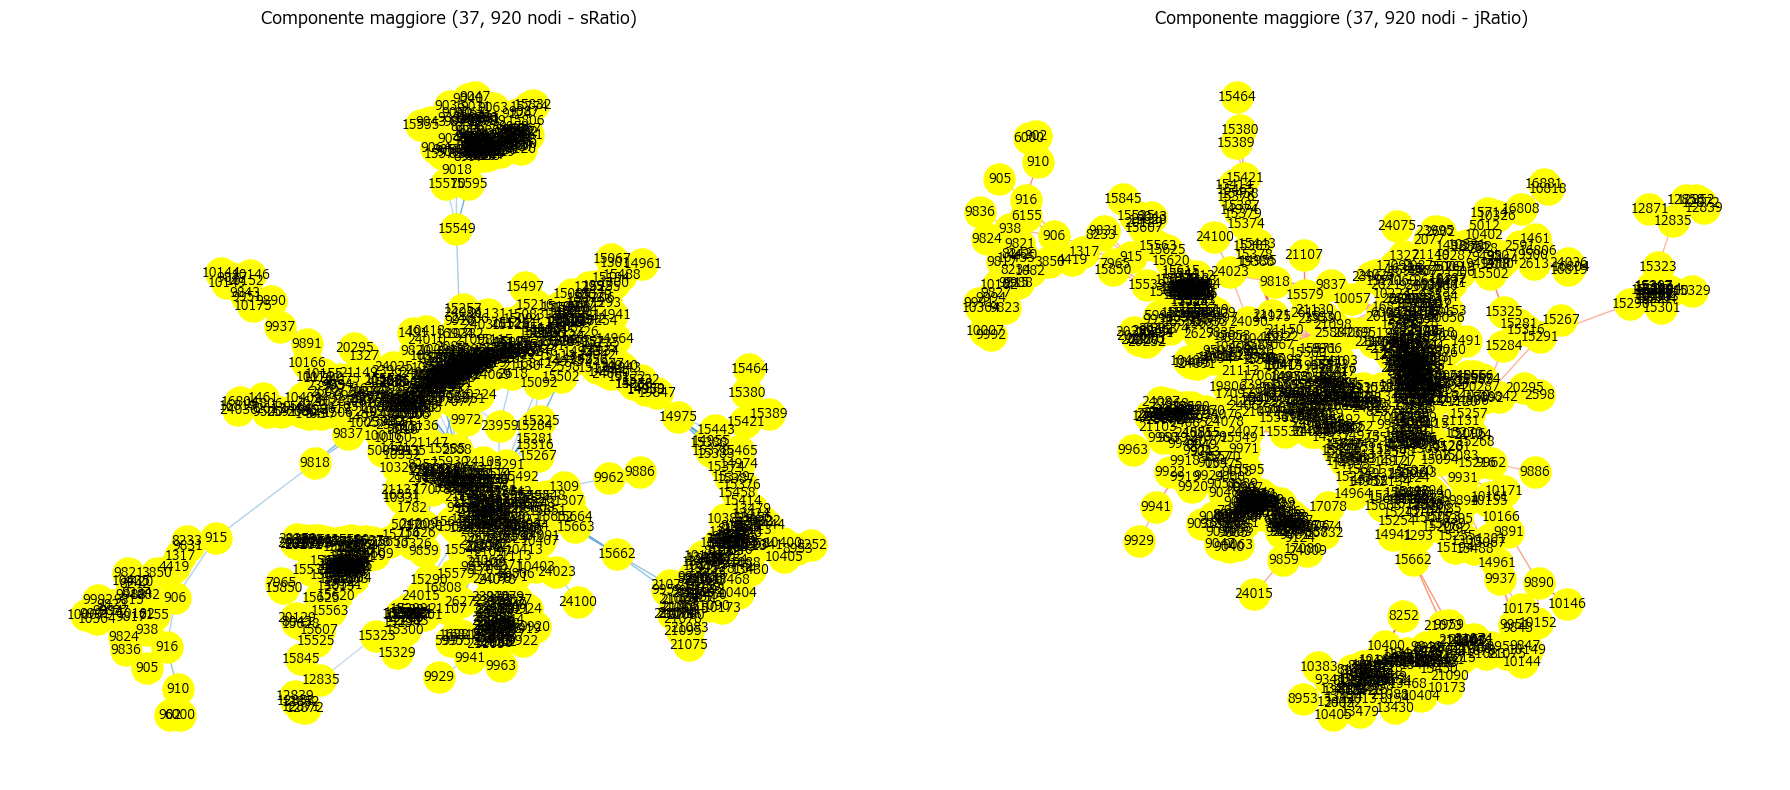

In [19]:
comps = list(nx.connected_components(g))
connComp = len(comps)


print(f"Il grafo è composto da {connComp} componenti connesse.")

lIndex, lComponent = max(enumerate(comps), key=lambda x: len(x[1]))

lID = lIndex + 1

print(f"Il componente più grande è il {lID} con {len(lComponent)} nodi.")

subgIndex = 1 if lID != 2 else 1

chrThreshold = 0.25

def componentGraph(g, id, ratio="sRatio", ax=None, title="Componenti connessi e componente maggiore"):
    try:
        graph = nx.subgraph(g, comps[id - 1])
        edges = list(graph.edges)
        weights = np.array([graph[u][v][ratio] for u, v in edges])

        minW, maxW = min(weights), max(weights)
        normWgh = (weights - minW) / (maxW - minW) if maxW != minW else np.ones_like(weights)
        normWgh = normWgh * (1 - chrThreshold) + chrThreshold

        cmap = plt.cm.Blues if ratio == 'sRatio' else plt.cm.Reds
        colors = cmap(normWgh)

        pos = nx.spring_layout(graph)
        nx.draw(graph, pos, with_labels=True, edge_color=colors, node_size=500,
                font_size=9, node_color='yellow', ax=ax)

        ax.set_title(f"{title}", fontsize=12)
    except Exception as e:
        print(f"Errore nella visualizzazione del componente [{id}]: {str(e)}")
        

fig1, axes1 = plt.subplots(1, 2, figsize=(18, 8))
componentGraph(g, subgIndex, ratio='sRatio', ax=axes1[0], title=f"Componente {subgIndex} (sRatio)")
componentGraph(g, subgIndex, ratio='jRatio', ax=axes1[1], title=f"Componente {subgIndex} (jRatio)")
plt.tight_layout()
plt.show()

fig2, axes2 = plt.subplots(1, 2, figsize=(18, 8))
componentGraph(g, lID, ratio='sRatio', ax=axes2[0], title=f"Componente maggiore ({lID}, {len(lComponent)} nodi - sRatio)")
componentGraph(g, lID, ratio='jRatio', ax=axes2[1], title=f"Componente maggiore ({lID}, {len(lComponent)} nodi - jRatio)")
plt.tight_layout()
plt.show()

## 2.5. Path Analysis

Analizziamo i **path** del grafo. Specifichiamo i nodi di partenza e di arrivo per controllare qual è il percorso più breve tra di essi (se fanno parte dello stesso subgraph):

In [20]:
begin = 1
end = 33

try:
    path = nx.shortest_path(g, source=begin, target=end)
    len = nx.shortest_path_length(g, source=begin, target=end)
    print(f"Percorso più breve da {g.nodes[begin]["name"]} a {g.nodes[end]["name"]} ({len})\n{path}")
except:
    print(f"Uno dei nodi non esiste oppure percorso non trovato da {g.nodes[begin]["name"]} a {g.nodes[end]["name"]}.")

Percorso più breve da Annalisa a Dargen D'Amico (3)
[1, 12, 29, 33]


Computiamo il **diametro** del subgraph in analisi. Dopo analizziamo la **distribuzione** dei diametri dei subgraphs del grafo:

Il diametro del subgraph 1 misura 9.

Misure dei diametri dei subgraphs e frequenze corrispondenti:
{9: 5, 5: 18, 20: 1, 23: 1, 1: 444, 3: 63, 8: 6, 11: 10, 13: 3, 2: 176, 10: 6, 4: 38, 7: 12, 6: 14, 27: 1, 12: 1, 15: 1}


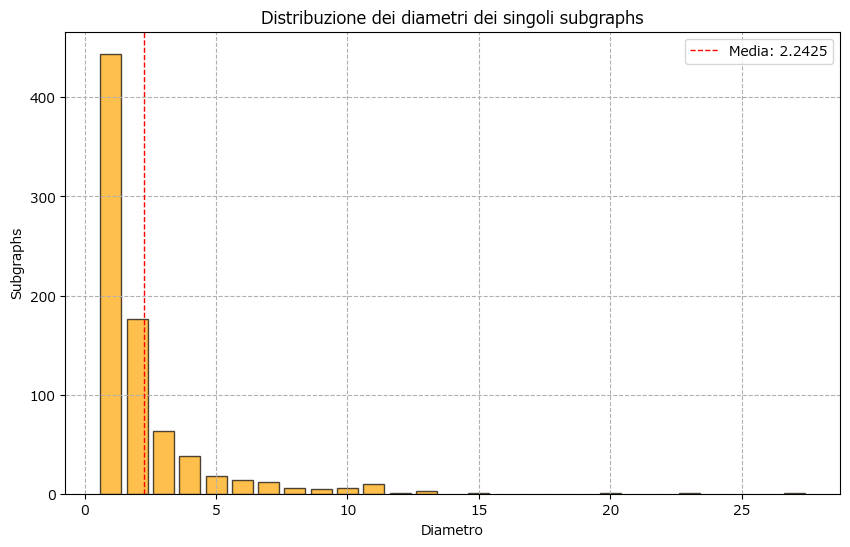

In [21]:
try:
    diameter = nx.diameter(g.subgraph(comps[subgIndex-1]))
    
    print(f"Il diametro del subgraph {subgIndex} misura {diameter}.\n")
    
    diameters = dict(Counter([nx.diameter(g.subgraph(c)) for c in comps]))
    
    print(f"Misure dei diametri dei subgraphs e frequenze corrispondenti:\n{dict(Counter(diameters))}")
    
    dValues = list(diameters.keys())
    freqs = list(diameters.values())
    avgDiameter = np.average(dValues, weights=freqs)

    color = "orange"

    plt.figure(figsize=(10, 6))
    plt.bar(dValues, freqs, color="orange", edgecolor="black", alpha=0.7)
    plt.axvline(avgDiameter, color="red", linestyle="dashed", linewidth=1, label=f"Media: {round(avgDiameter, 4)}")
    plt.grid(True, linestyle="--")

    plt.xlabel("Diametro")
    plt.ylabel("Subgraphs")
    plt.title("Distribuzione dei diametri dei singoli subgraphs")
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Subgraph {subgIndex} non esistente.\n{e}")

## 2.6. Clustering e Densità

Analizziamo il **clustering** e la **densità** del grafo.

### Clustering

Visualizziamo l'elenco dei coefficienti di clustering dei singoli nodi del grafo. Sotto si calcola anche il clustering medio:

In [22]:
clCoeffs = nx.clustering(g, nodes=sorted(g.nodes()))

avgClst = nx.average_clustering(g)

print(f"Clustering medio: {round(avgClst, 5)}")

for node in sorted(g.nodes()):
    name = g.nodes[node].get("name", "-")
    clustering = clCoeffs[node]
    print(f"{node}. {name} - {clustering:.5f}")

Clustering medio: 0.51646
1. Annalisa - 0.58867
2. Giorgio Vanni - 0.86140
3. Katy Perry - 0.57143
4. Ado - 0.00000
5. Elodie - 1.00000
6. Emma - 0.71795
7. Angelina Mango - 0.66667
8. Rose Villain - 0.00000
9. Clara - 0.42857
10. Francesca Michielin - 0.70330
11. Mahmood - 1.00000
12. The Kolors - 0.78207
15. Marco Mengoni - 0.71111
16. Alessandra Amoroso - 0.86036
18. Levante - 0.76049
19. Noemi - 0.79160
20. Paola & Chiara - 0.71429
21. Tananai - 0.69535
22. sangiovanni - 0.79061
23. Elettra Lamborghini - 0.00000
24. Giorgia - 0.75277
26. Arisa - 0.83486
27. Baby K - 0.72222
28. Alfa - 0.38889
29. Fedez - 0.66071
30. Loredana Bertè - 0.70277
31. Giusy Ferreri - 0.84764
32. La rappresentante di lista - 0.97533
33. Dargen D'Amico - 0.70330
34. Diodato - 0.83443
35. Pinguini Tattici Nucleari - 0.63899
36. Michele Bravi - 0.79091
37. Francesco Gabbani - 0.84794
38. Tiziano Ferro - 0.88332
39. Ermal Meta - 0.77622
40. Coma_Cose - 0.62791
41. Ghali - 0.46769
42. Takagi & Ketra - 0.93750
4

### Densità

In [23]:
density = np.format_float_scientific(nx.density(g), precision=5, exp_digits=2)
print(f"La densità è di {density}.")

La densità è di 1.43388e-03.


Calcoliamo la densità di ciascun subgraph:

Densità media dei sottografi: 0.7713


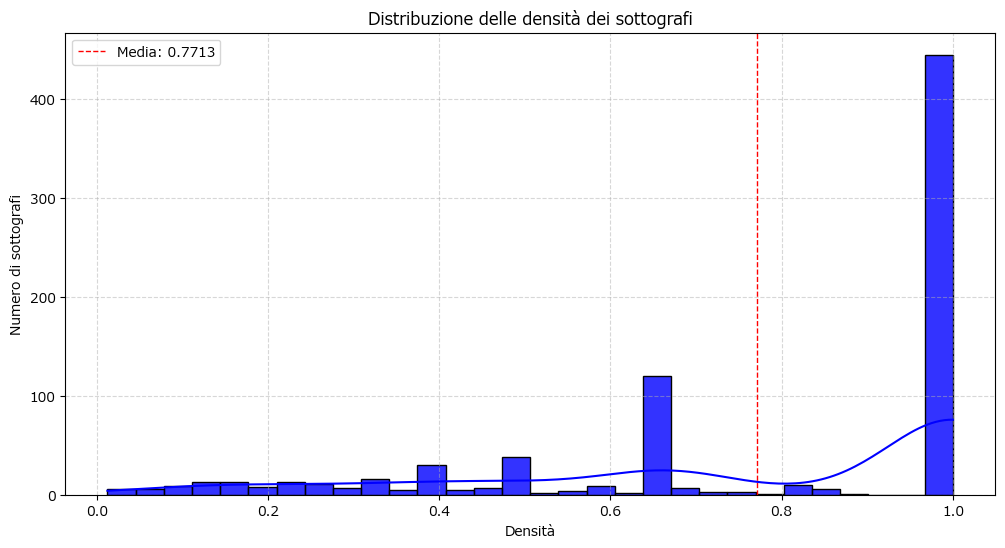

In [24]:
components = list(nx.connected_components(g))

subDensities = [nx.density(g.subgraph(c)) for c in components]
avgDensity = np.mean(subDensities)

print(f"Densità media dei sottografi: {avgDensity:.4f}")

plt.figure(figsize=(12, 6))
sns.histplot(subDensities, bins=30, kde=True, color="blue", edgecolor="black", alpha=0.8)

plt.axvline(avgDensity, color="red", linestyle="dashed", linewidth=1, label=f"Media: {round(avgDensity, 4)}")

plt.xlabel("Densità")
plt.ylabel("Numero di sottografi")
plt.title("Distribuzione delle densità dei sottografi")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


## 2.7. Centralities

Analizziamo di seguito le **centralità** del grafo. La **Degree Centrality** è stata analizzata nel **paragrafo 2.2**.

### Closeness Centrality

Ecco la lista delle Closeness Centralities del dataset:

In [25]:
srtNodes = sorted(g.nodes())
closeness = nx.closeness_centrality(g)

srtClsns = [(g.nodes[node].get("name", "-"), closeness[node]) for node in srtNodes]

print(f"Closeness Centrality")
for node in srtNodes:
    name = g.nodes[node].get("name", "-")
    centrality = closeness[node]
    print(f"{node}. {name} - {centrality:.5f}")

Closeness Centrality
1. Annalisa - 0.00867
2. Giorgio Vanni - 0.01130
3. Katy Perry - 0.00617
4. Ado - 0.00835
5. Elodie - 0.00662
6. Emma - 0.00754
7. Angelina Mango - 0.00723
8. Rose Villain - 0.00557
9. Clara - 0.00724
10. Francesca Michielin - 0.00818
11. Mahmood - 0.00699
12. The Kolors - 0.01000
15. Marco Mengoni - 0.00735
16. Alessandra Amoroso - 0.00879
18. Levante - 0.01049
19. Noemi - 0.01060
20. Paola & Chiara - 0.00749
21. Tananai - 0.01158
22. sangiovanni - 0.00957
23. Elettra Lamborghini - 0.00639
24. Giorgia - 0.01060
26. Arisa - 0.01036
27. Baby K - 0.00842
28. Alfa - 0.00780
29. Fedez - 0.01049
30. Loredana Bertè - 0.01095
31. Giusy Ferreri - 0.00988
32. La rappresentante di lista - 0.00942
33. Dargen D'Amico - 0.00940
34. Diodato - 0.01004
35. Pinguini Tattici Nucleari - 0.01224
36. Michele Bravi - 0.00926
37. Francesco Gabbani - 0.01013
38. Tiziano Ferro - 0.01016
39. Ermal Meta - 0.00974
40. Coma_Cose - 0.01213
41. Ghali - 0.01036
42. Takagi & Ketra - 0.00901
43. SA

Generiamo il grafico che mostra i primi 20 artisti per closeness decrescente:

Artisti per Closeness Centrality
1. Keith Urban - 0.01429
2. Darius Rucker - 0.01403
3. Little Big Town - 0.01399
4. Rascal Flatts - 0.01399
5. Dierks Bentley - 0.01384
6. Sugarland - 0.01381
7. Blake Shelton - 0.01365
8. Eli Young Band - 0.01365
9. Brad Paisley - 0.01362
10. David Nail - 0.01362
11. Tim McGraw - 0.01356
12. Scotty McCreery - 0.01356
13. Kenny Chesney - 0.01356
14. Nivea - 0.01353
15. Easton Corbin - 0.01353
16. Chris Young - 0.01350
17. Billy Currington - 0.01350
18. Lady Antebellum - 0.01347
19. The Band Perry - 0.01347
20. Jason Aldean - 0.01347
21. Adriana Calcanhotto - 0.01346
22. Miranda Lambert - 0.01344
23. Frankie Ballard - 0.01341
24. Cole Swindell - 0.01338
25. Jake Owen - 0.01338
26. Luke Bryan - 0.01335
27. Dustin Lynch - 0.01335
28. Eric Paslay - 0.01335
29. LeToya - 0.01333
30. Lee Brice - 0.01332
31. Randy Houser - 0.01332
32. Eric Church - 0.01330
33. Old Dominion - 0.01330
34. Ashanti - 0.01327
35. Florida Georgia Line - 0.01327
36. Jana Kramer - 0.01

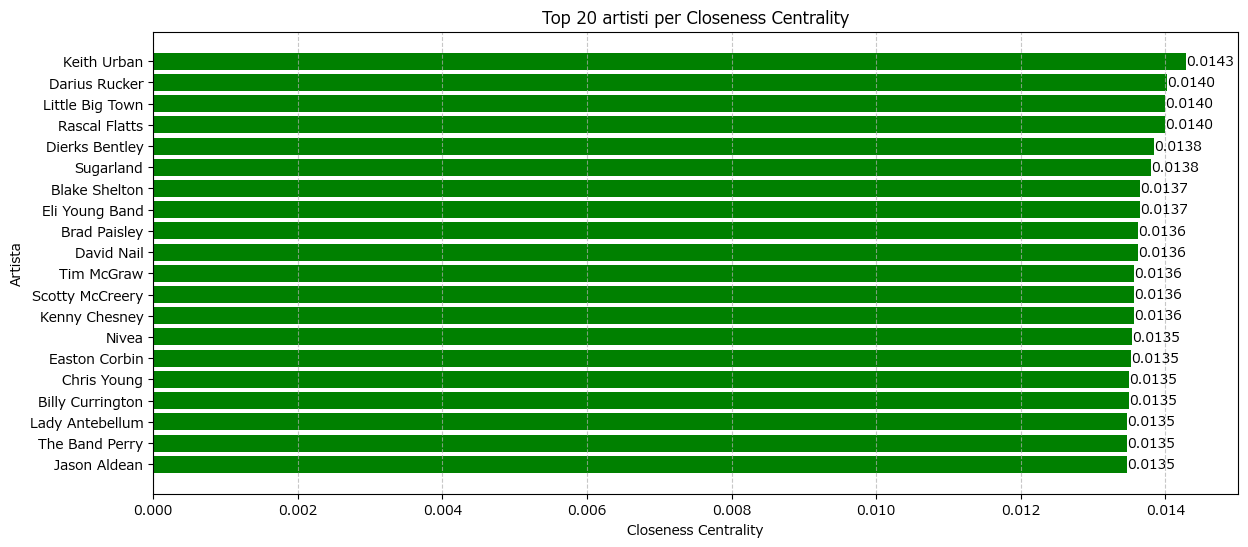

In [26]:
srtClsns = sorted(
    [(g.nodes[node].get("name", "-"), closeness[node]) for node in srtNodes],
    key=lambda x: x[1],
    reverse=True
)

print(f"Artisti per Closeness Centrality")
for i, (name, centrality) in enumerate(srtClsns):
    print(f"{i+1}. {name} - {centrality:.5f}")
    
names, topCls = zip(*srtClsns[:20])

plt.figure(figsize=(14, 6))
plt.barh(names, topCls, color="green")
plt.xlabel("Closeness Centrality")
plt.ylabel("Artista")
plt.title("Top 20 artisti per Closeness Centrality")
plt.gca().invert_yaxis()

for i, v in enumerate(topCls):
    plt.text(v, i, f"{v:.4f}", va="center", fontsize=10)

plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

### Betweenness Centrality

Svolgiamo il medesimo calcolo ma per la Betweenness Centrality:

In [27]:
betweenness = nx.betweenness_centrality(g)
srtBtwns = [(g.nodes[node].get("name", "-"), betweenness[node]) for node in srtNodes]

print(f"Betweenness Centrality")
for node in srtNodes:
    name = g.nodes[node].get("name", "-")
    centrality = betweenness[node]
    print(f"{node}. {name} - {centrality:.5f}")

Betweenness Centrality
1. Annalisa - 0.00001
2. Giorgio Vanni - 0.00001
3. Katy Perry - 0.00003
4. Ado - 0.00000
5. Elodie - 0.00000
6. Emma - 0.00000
7. Angelina Mango - 0.00000
8. Rose Villain - 0.00000
9. Clara - 0.00000
10. Francesca Michielin - 0.00000
11. Mahmood - 0.00000
12. The Kolors - 0.00001
15. Marco Mengoni - 0.00000
16. Alessandra Amoroso - 0.00000
18. Levante - 0.00000
19. Noemi - 0.00000
20. Paola & Chiara - 0.00000
21. Tananai - 0.00001
22. sangiovanni - 0.00000
23. Elettra Lamborghini - 0.00000
24. Giorgia - 0.00000
26. Arisa - 0.00000
27. Baby K - 0.00000
28. Alfa - 0.00000
29. Fedez - 0.00001
30. Loredana Bertè - 0.00000
31. Giusy Ferreri - 0.00000
32. La rappresentante di lista - 0.00000
33. Dargen D'Amico - 0.00001
34. Diodato - 0.00000
35. Pinguini Tattici Nucleari - 0.00001
36. Michele Bravi - 0.00000
37. Francesco Gabbani - 0.00000
38. Tiziano Ferro - 0.00000
39. Ermal Meta - 0.00001
40. Coma_Cose - 0.00005
41. Ghali - 0.00005
42. Takagi & Ketra - 0.00000
43. 

E il grafico corrispondente:

Artisti per Betweenness Centrality
1. Mr. Mister - 0.00295
2. Eddie Money - 0.00180
3. Culture Club - 0.00151
4. Rick Springfield - 0.00136
5. Supertramp - 0.00129
6. Manfred Mann's Earth Band - 0.00128
7. Roger Hodgson - 0.00127
8. Bob Seger - 0.00127
9. Sid - 0.00121
10. Chicago - 0.00119
11. The Animals - 0.00113
12. The Spencer Davis Group - 0.00111
13. Quarterflash - 0.00108
14. Egoist - 0.00094
15. Nightmare - 0.00093
16. Sayuri - 0.00092
17. Rory Gallagher - 0.00091
18. James Gang - 0.00090
19. アンジェラ・アキ - 0.00086
20. Ten Years After - 0.00086
21. the GazettE - 0.00083
22. 樹海 - 0.00082
23. AZU - 0.00082
24. RSP - 0.00082
25. Eir Aoi - 0.00081
26. 福原美穂 - 0.00081
27. Vickeblanka - 0.00080
28. Nothing's Carved In Stone - 0.00080
29. Genesis - 0.00079
30. Steppenwolf - 0.00073
31. Ryokuoushoku Shakai - 0.00071
32. THE ORAL CIGARETTES - 0.00066
33. BURNOUT SYNDROMES - 0.00065
34. 奥田民生 - 0.00065
35. 中村一義 - 0.00065
36. Keri Hilson - 0.00064
37. GRAPEVINE - 0.00064
38. Who-ya Extended - 

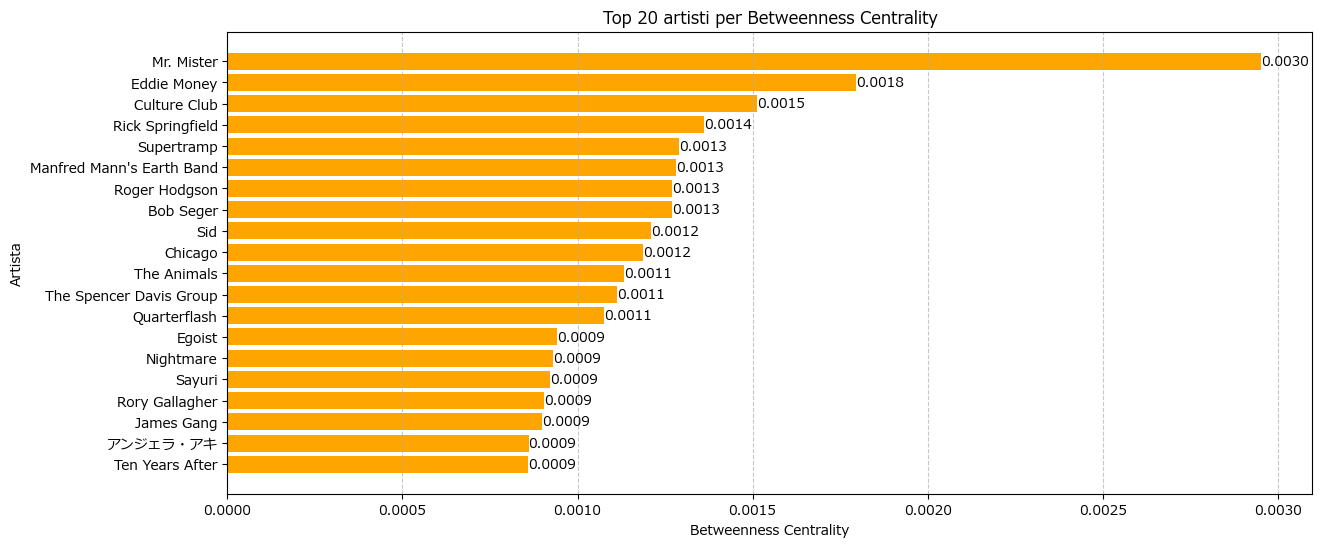

In [28]:
srtBtwns = sorted(
    [(g.nodes[node].get("name", "-"), betweenness[node]) for node in srtNodes],
    key=lambda x: x[1],
    reverse=True
)

print(f"Artisti per Betweenness Centrality")
for i, (name, centrality) in enumerate(srtBtwns):
    print(f"{i+1}. {name} - {centrality:.5f}")
    
names, topBtwns = zip(*srtBtwns[:20])

plt.figure(figsize=(14, 6))
plt.barh(names, topBtwns, color="orange")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Artista")
plt.title("Top 20 artisti per Betweenness Centrality")
plt.gca().invert_yaxis()

for i, v in enumerate(topBtwns):
    plt.text(v, i, f"{v:.4f}", va="center", fontsize=10)

plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

⬅️ 1. [Data Collection](../data_collection/1_data.ipynb)

➡️ 3. [Open Problem](../open_problem/3_open_problem.ipynb)